In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
from module.process import process
from module.swingometer import swingometer
from module.battleground import battleground
from module.forecast import forecast

In [3]:
raw = pd.read_csv(r'C:\Users\Andy\Documents\PolUK\Election Data\electdata_2015.txt',sep=';')
data = process(raw)

In [4]:
player_seats = {
    'Bognor Regis and Littlehampton':'Robert Lascelles', # Me
    'Liverpool Riverside':'James Arnold', # Nathon
    'Nottingham South':'Sarah Nyland', # Sinan
    'Rhondda':'Mitch Un', # Batman
    'Dorset North':'William Croft', # Croft
    'Dumfriesshire, Clydesdale and Tweeddale':'Calum Wilson', # CDW
    'Holborn and St Pancras':'David Levy', # Barclay
    'Manchester Central':'Caroline Blakesley',# Blakesley
    'Leeds North West':'Grant Smith', # Gianni
}
assert len(player_seats)==data[data.Name.isin(player_seats.keys())].shape[0]
data['MP'] = data['Name'].map(player_seats).fillna(data['MP'])

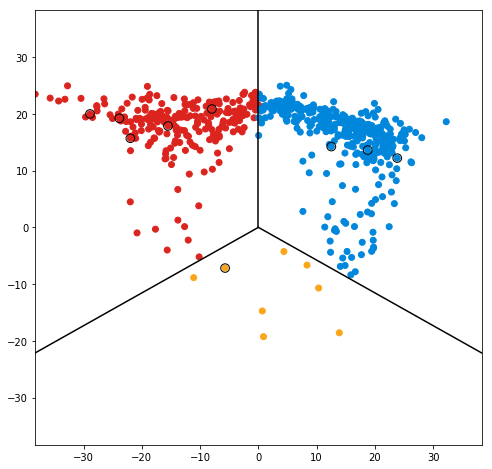

In [6]:
battleground(data, ['LAB', 'CON', 'LIB'], highlight=player_seats.keys())

In [7]:
data.loc[(data.Name.isin(player_seats.keys()))&(data.Swing_to_gain_pct<5),
        ['Name','MP','Area','County','Winner','Swing_to_gain_pct']
        ].sort_values('Swing_to_gain_pct')

,Name,MP,Area,County,Winner,Swing_to_gain_pct
588,"Dumfriesshire, Clydesdale and Tweeddale",Calum Wilson,2,Dumfries and Galloway,CON,0.765335
275,Leeds North West,Grant Smith,5,West Yorkshire,LIB,3.352400


In [8]:
extra_swing = 0

# IG Pre-Round polls
polling = {'CON':  np.mean([38,35,40,39])+extra_swing,
           'LAB':  np.mean([26,39,32,31])-extra_swing,
           'LIB':  np.mean([ 7,10, 5, 5]),
           'Green':np.mean([ 4, 2, 4, 3]),
           'UKIP': np.mean([ 0, 0, 0, 0]),
          }
scottish_polling = {'CON':  np.mean([27])+extra_swing,
                    'LAB':  np.mean([22])-extra_swing,
                    'LIB':  np.mean([ 7]),
                    'NAT':  np.mean([37]),
                    'Green':np.mean([ 2]),
                    'UKIP': np.mean([ 0]),
                   }
welsh_polling = {'CON':  np.mean([26])+extra_swing,
                 'LAB':  np.mean([33])-extra_swing,
                 'LIB':  np.mean([ 7]),
                 'NAT':  np.mean([15]),
                 'Green':np.mean([ 2]),
                 'UKIP': np.mean([ 4]),
                }

# RL Late-May/Early-June 2019 polls
#polling = {'CON':  np.mean([18,20,17,19,18,18])+extra_swing,
#           'LAB':  np.mean([19,26,22,19,20,19])-extra_swing,
#           'LIB':  np.mean([23,16,16,24,20,22]),
#           'Green':np.mean([10, 5,11, 8, 9, 9]),
#           'UKIP': np.mean([23,24,26,22,26,25]),
#          }
#scottish_polling = {'CON':  np.mean([18])+extra_swing,
#                    'LAB':  np.mean([19])-extra_swing,
#                    'LIB':  np.mean([10]),
#                    'NAT':  np.mean([38]),
#                    'Green':np.mean([3]),
#                    'UKIP': np.mean([9]),
#                   }
#welsh_polling = {'CON': np.mean([17])+extra_swing,
#                 'LAB': np.mean([25])-extra_swing,
#                 'LIB': np.mean([12]),
#                 'NAT': np.mean([13]),
#                 'Green':np.mean([5]),
#                 'UKIP': np.mean([23]),
#                }

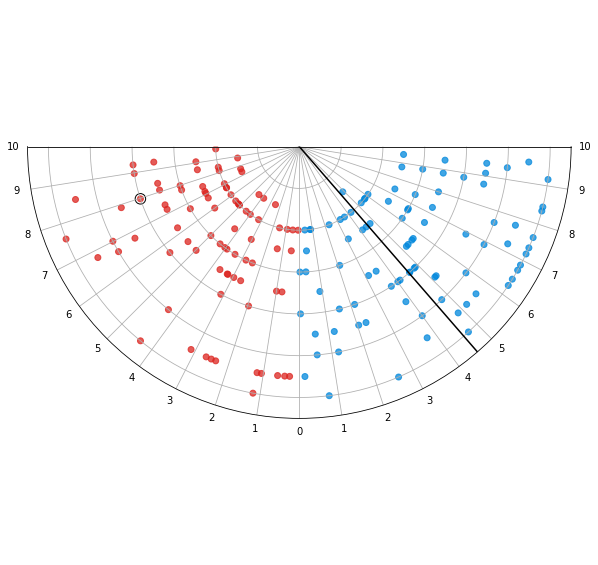

In [11]:
swingometer(data, ['LAB', 'CON'], shift=polling, 
            highlight=list(player_seats.keys()))

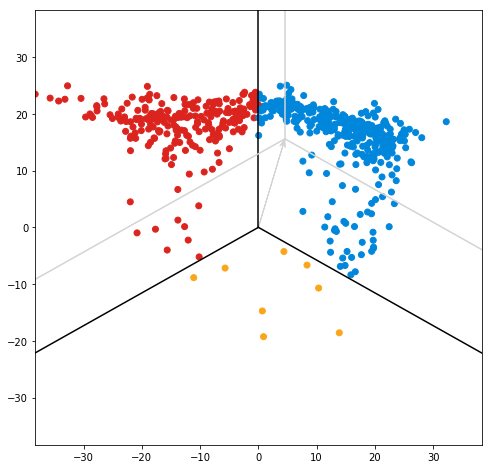

In [9]:
battleground(data, ['LAB', 'CON', 'LIB'], shift=polling)

In [13]:
forecast_data = forecast(data, polling, scottish_polling, welsh_polling)

In [14]:
forecast_data['Winner_forecast'].value_counts()

LAB      229
CON      223
UKIP      70
LIB       57
NAT       51
Green      2
Name: Winner_forecast, dtype: int64

In [15]:
largest_party = forecast_data['Winner_forecast'].value_counts().head(1)
if largest_party[0]>650/2:
    print('{} majority: {}'.format(largest_party.index[0],largest_party[0]*2 - 650))
else:
    print('{} largest party, short by {}'.format(largest_party.index[0],int((650/2)-largest_party[0])))

LAB largest party, short by 96


In [17]:
pd.crosstab(forecast_data['Winner'],forecast_data['Winner_forecast'],margins=True, margins_name='Total')

Winner_forecast,CON,Green,LAB,LIB,NAT,UKIP,Total
Winner,,,,,,,
CON,220,0,22,37,0,52,331
Green,0,1,0,0,0,0,1
LAB,0,1,206,7,1,17,232
LIB,0,0,0,8,0,0,8
NAT,3,0,1,5,50,0,59
UKIP,0,0,0,0,0,1,1
Total,223,2,229,57,51,70,632


In [16]:
forecast_data.loc[~forecast_data['Winner_forecast'].isin(['CON','LAB','LIB','NAT']),
             ['Name','MP','Region','County','Winner','Winner_forecast']]

,Name,MP,Region,County,Winner,Winner_forecast
3,Amber Valley,Nigel Mills,East Midlands,Derbyshire,CON,UKIP
5,Ashfield,Gloria de Piero,East Midlands,Nottinghamshire,LAB,UKIP
15,Basildon South and East Thurrock,Stephen Metcalfe,Anglia,Essex,CON,UKIP
32,Bexleyheath and Crayford,David Evennett,London,Bexley,CON,UKIP
46,Blackpool North and Cleveleys,Paul Maynard,North West,Lancashire,CON,UKIP
...,...,...,...,...,...,...
461,Thurrock,Jackie Doyle-Price,Anglia,Essex,CON,UKIP
477,Walsall North,David Winnick,West Midlands,Black Country,LAB,UKIP
486,Warwickshire North,Craig Tracey,West Midlands,Warwickshire,CON,UKIP
501,Weston-Super-Mare,John Penrose,South West,Bristol area,CON,UKIP


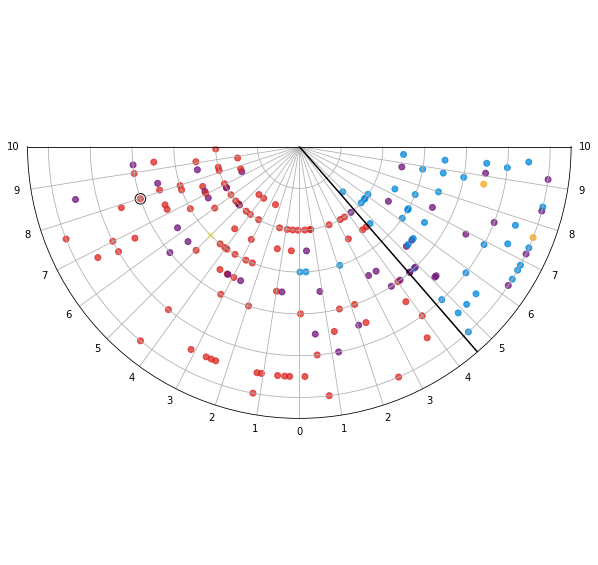

In [19]:
swingometer(forecast_data, ['LAB', 'CON'], colour_by='Winner_forecast',
            shift=polling, 
            highlight=list(player_seats.keys()))

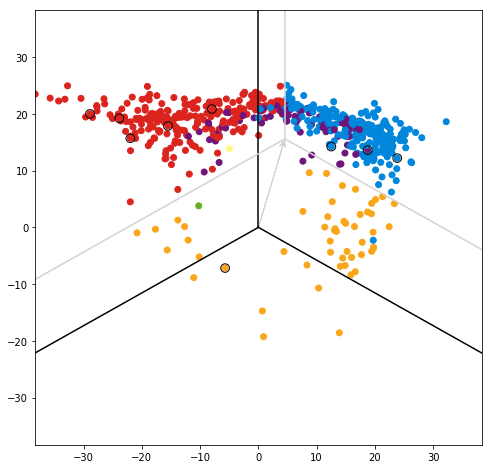

In [18]:
battleground(forecast_data, ['LAB', 'CON', 'LIB'], colour_by='Winner_forecast',
            shift=polling, 
            highlight=list(player_seats.keys()))

In [20]:
forecast_data.loc[(forecast_data.Winner!=forecast_data.Winner_forecast)&(forecast_data['Name'].isin(player_seats.keys())),['Name','MP','Region','County','Winner','Winner_forecast','Swing_to_gain_after_forecast_pct','Probability']].sort_values('Probability')

,Name,MP,Region,County,Winner,Winner_forecast,Swing_to_gain_after_forecast_pct,Probability
50,Bognor Regis and Littlehampton,Robert Lascelles,South East,West Sussex,CON,UKIP,0.648807,0.646976


In [21]:
forecast_data.loc[(forecast_data.Winner==forecast_data.Winner_forecast)&(forecast_data['Name'].isin(player_seats.keys())),['Name','MP','Region','County','Winner','Winner_forecast','Swing_to_gain_after_forecast_pct','Probability']].sort_values('Probability')

,Name,MP,Region,County,Winner,Winner_forecast,Swing_to_gain_after_forecast_pct,Probability
157,Dorset North,William Croft,South West,Dorset,CON,CON,4.332637,0.951077
565,Rhondda,Mitch Un,Wales,Mid Glamorgan,LAB,LAB,5.444129,0.973051
340,Nottingham South,Sarah Nyland,East Midlands,Nottinghamshire,LAB,LAB,7.275037,0.989908
588,"Dumfriesshire, Clydesdale and Tweeddale",Calum Wilson,Scotland,Dumfries and Galloway,CON,CON,8.294132,0.994159
244,Holborn and St Pancras,David Levy,London,Camden,LAB,LAB,11.996355,0.999198
304,Manchester Central,Caroline Blakesley,North West,Central Manchester,LAB,LAB,14.184015,0.999752
275,Leeds North West,Grant Smith,Yorks / Humber,West Yorkshire,LIB,LIB,14.579273,0.999799
290,Liverpool Riverside,James Arnold,North West,Merseyside,LAB,LAB,19.969582,0.999989
